In [1]:
import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt
from nt_toolbox.general import *
from nt_toolbox.signal import *

# Plot an image

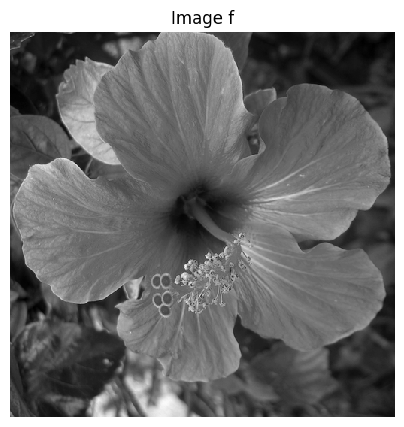

In [3]:
n0 = 512
f = rescale(load_image("nt_toolbox/data/hibiscus.bmp", n0))
plt.figure(figsize = (5, 5))
imageplot(f, "Image f")

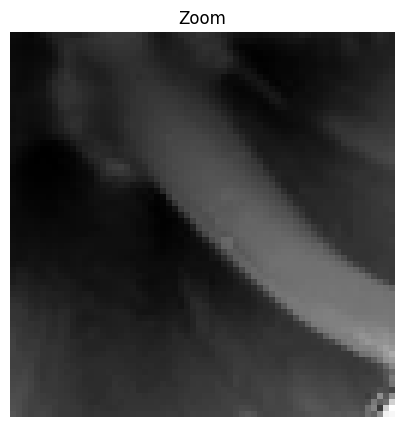

In [4]:
plt.figure(figsize = (5, 5))
imageplot(f[n0//2 - 32:n0//2 + 32, n0//2 - 32:n0//2 + 32], "Zoom")

# Fourier Transform

In [5]:
F = pyl.fft2(f)/n0 # forward transform
from pylab import linalg
print("Energy of Image: %f" %linalg.norm(f))
print("Energy of Fourier: %f" %linalg.norm(F))

Energy of Image: 205.747421
Energy of Fourier: 205.747421


> Why is the signal energy preserved in the frequency domain?

[**Parseval's Theorem**](https://en.wikipedia.org/wiki/Parseval%27s_theorem). The Fourier transform be considered as a change of basis, and as the basis matrix of the new, frequency-domain representation of the signal is an orthonormal matrix, then the transformation can be seen as a (norm-preserving) rotation. The identity holds for the L1 and L2 norms of signals (where the energy of signal is its L2 norm).

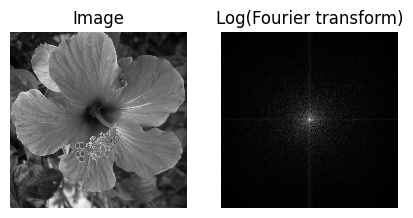

In [10]:
L = pyl.fftshift(np.log(abs(F) + 1e-1))
plt.figure(figsize = (5, 5))
imageplot(f, "Image", [1, 2, 1])
imageplot(L, "Log(Fourier transform)", [1, 2, 2])

# Filtering

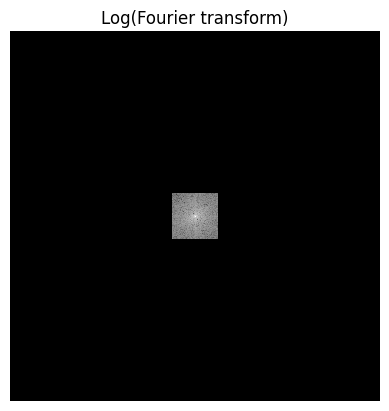

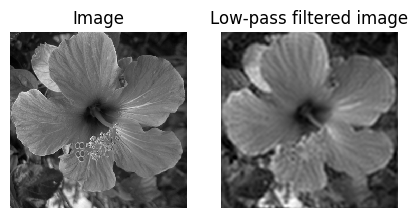

In [12]:
M = n0**2//64
q = int(np.sqrt(M))
F = pyl.fftshift(pyl.fft2(f))
Sel = np.zeros([n0, n0])
Sel[n0//2 - q//2:n0//2 + q//2, n0//2 - q//2:n0//2 + q//2] = 1
F_zeros = np.multiply(F, Sel)
imageplot(np.log(abs(F_zeros) + 1e-1), "Log(Fourier transform)") # plot in frequency domain
f_lpf = np.real(pyl.ifft2(pyl.fftshift(F_zeros))) # inverse transform
plt.figure(figsize = (5, 5))
imageplot(f, "Image", [1, 2, 1])
imageplot(clamp(f_lpf), "Low-pass filtered image", [1, 2, 2])

> Can you observe the difference between the original image and the filtered one?

Low-pass filtering excludes higher frequency components before reconstructing (top image). As a direct consequence of this, the low-pass filtered image appears blurred, as higher frequency components like edges and details are cut out from the filter.

> Now perform a high-pass filtering (how can you do this?). Can you explain the filtering outcome?

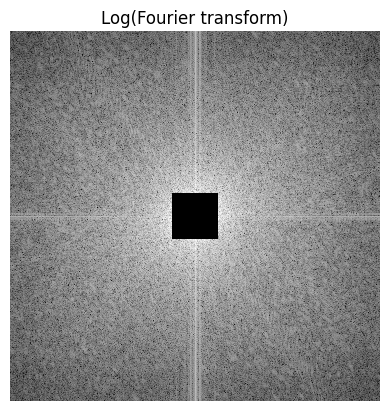

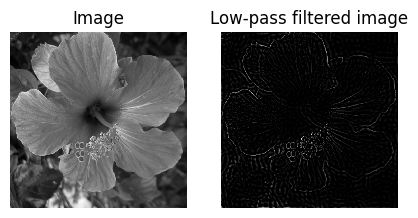

In [14]:
M = n0**2//64
q = int(np.sqrt(M))
F = pyl.fftshift(pyl.fft2(f))
Sel = np.zeros([n0, n0])
Sel[n0//2 - q//2 : n0//2 + q//2, n0//2 - q//2 : n0//2 + q//2] = 1

# invert the low-pass filter! 
Sel = 1 - Sel

F_zeros = np.multiply(F, Sel)
imageplot(np.log(abs(F_zeros) + 1e-1), "Log(Fourier transform)") # plot in frequency domain
f_lpf = np.real(pyl.ifft2(pyl.fftshift(F_zeros))) # inverse transform
plt.figure(figsize = (5, 5))
imageplot(f, "Image", [1, 2, 1])
imageplot(clamp(f_lpf), "Low-pass filtered image", [1, 2, 2])

In this second examples, edges are all that is present in the reconstructed image, as the low frequency components associated are filtered out (see the "hollow" top image).
As high frequency components correspond to edges, the image's output contains those only.

# Fourier-based vs wavelet-based approximation.

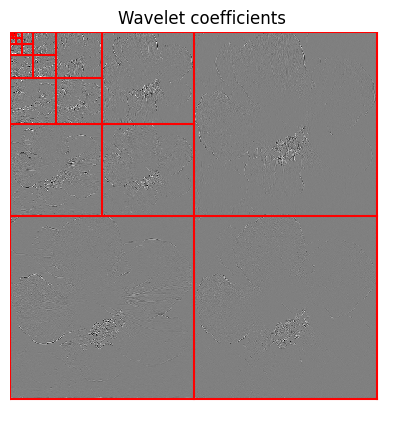

In [16]:
Jmin = 0
from nt_toolbox.perform_wavelet_transf import *
Fw = perform_wavelet_transf(f, Jmin, + 1) # forward transform
plt.figure(figsize = (5, 5))
plot_wavelet(Fw)
plt.title("Wavelet coefficients")
plt.show()

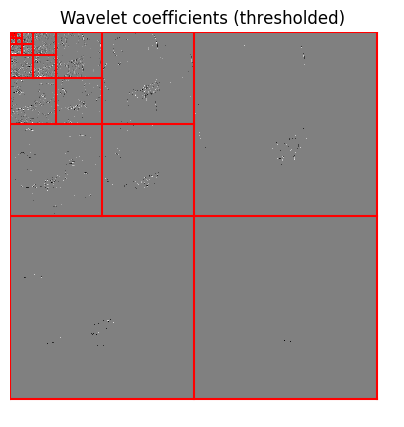

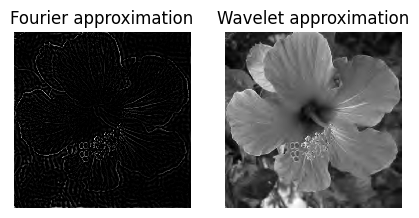

In [20]:
a = np.sort(np.ravel(abs(Fw)))[::-1] # sort a 1D copy of magnitude of fw in descending order
Fw_zeros = np.multiply(Fw,(abs(Fw) > a[M])) # keeping the M largest wavelet coefficients
plt.figure(figsize = (5, 5))
plot_wavelet(Fw_zeros) # comaprwe with the plot of coefficients above
plt.title("Wavelet coefficients (thresholded)")
plt.show()
f_wav = perform_wavelet_transf(Fw_zeros, Jmin, -1) # inverse transform
plt.figure(figsize = (5, 5))
imageplot(clamp(f_lpf), "Fourier approximation", [1, 2, 1])
imageplot(clamp(f_wav), "Wavelet approximation", [1, 2, 2])

> Can you comment on the comparison between the two approximations above. Why is one better than the other?

The first approximation retains only the coarsest scale, resulting in a blurred version of the image that captures overall stark variations only but misses low-frequency elements (which are giving images ). The second approximation includes additional scales (or more coefficients), preserving local structures and edges. Hence, it provides a visually and numerically better reconstruction, as it retains more of the signal’s energy and spatial information.

# Linear Denoising

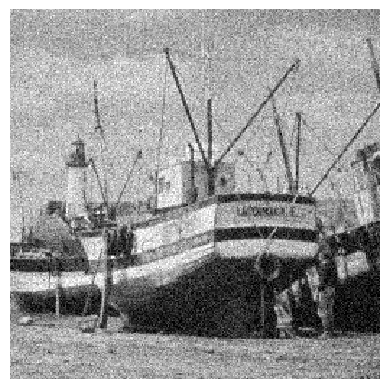

In [22]:
n = 256
N = n**2
name = "nt_toolbox/data/boat.bmp"
f = load_image(name, n)
plt.close("all")

imageplot(f)
sigma = .08
y = f + sigma*np.random.standard_normal(f.shape)
imageplot(clamp(y))

In [23]:
cconv = lambda a, b : np.real( pyl.ifft2(pyl.fft2(a)*pyl.fft2(b)) )
normalize = lambda h : h/sum(h.flatten())
t = np.transpose( np.concatenate( (np.arange(0, n/2), np.arange(-n/2, 0) ) ) )
[Y, X] = np.meshgrid(t, t)
h = lambda mu: normalize(np.exp(-(X**2 + Y**2)/ (2*mu**2)))

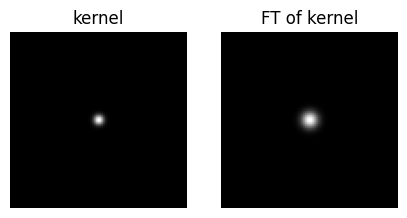

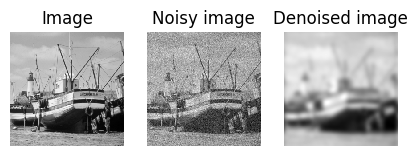

In [24]:
mu = 5
plt.figure(figsize = (5, 5))
imageplot(pyl.fftshift(h(mu)), "kernel", [1, 2, 1])
imageplot(pyl.fftshift(np.real(pyl.fft2(h(mu)))), "FT of kernel", [1, 2, 2])
denoise = lambda x, mu : cconv(h(mu), x)
plt.figure(figsize = (5, 5))
imageplot(f, "Image", [1, 3, 1])
imageplot(y, "Noisy image", [1, 3, 2])
imageplot(denoise(y, mu), "Denoised image", [1, 3, 3])

> Why is this denoising strategy linear?

This denoising strategy leverages the LTI interpretation of signal processing, and is also linear in the frequency domain as it relies on convolution.

> Vary the kernel width µ, and compare the denoising outcome.

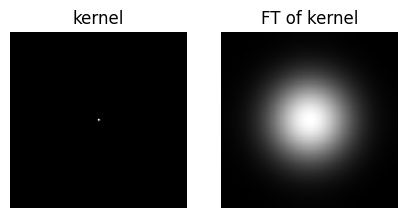

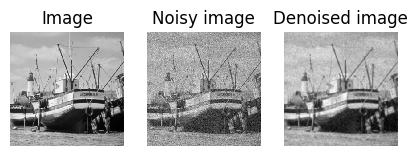

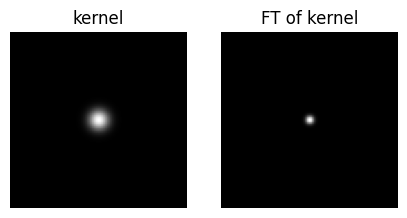

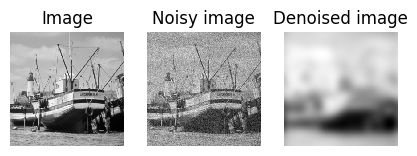

In [26]:
mus = [1,10]
for mu in mus:
    plt.figure(figsize = (5, 5))
    imageplot(pyl.fftshift(h(mu)), "kernel", [1, 2, 1])
    imageplot(pyl.fftshift(np.real(pyl.fft2(h(mu)))), "FT of kernel", [1, 2, 2])
    denoise = lambda x, mu : cconv(h(mu), x)
    plt.figure(figsize = (5, 5))
    imageplot(f, "Image", [1, 3, 1])
    imageplot(y, "Noisy image", [1, 3, 2])
    imageplot(denoise(y, mu), "Denoised image", [1, 3, 3])

Increased values of $\mu$ result in more blurred images as a direct consequence of the reduced time-domain resolution associated with increasing the "breadth" (receptive field?) of the convolutional filter. As for Heisemberg windows, the higher the resolution in the time domain, the smaller in the frequency domain. 
Viceversa, smaller values of $ \mu $ result in crisper, higher-resolution images as a consequence of more localized filters.

> Can you find an optimal µ that minimises the 2-norm of the difference between original and denoised image?

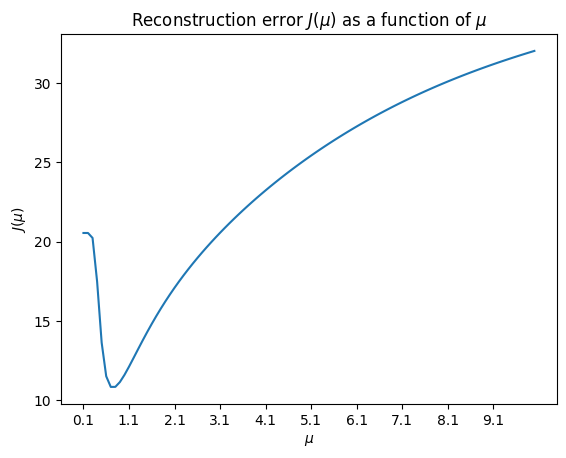

In [44]:
mus = np.linspace(0.1, 10, 100)
J_mus = []

for mu in mus:
    denoise = lambda x, mu : cconv(h(mu), x)
    y_hat= denoise(y, mu)
    
    J_mus.append(np.linalg.norm(f - y_hat))

fig, ax = plt.subplots()
ax.plot(mus, J_mus)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$J(\mu)$')
ax.set_xticks(mus[::10])
ax.set_title(r'Reconstruction error $J(\mu)$ as a function of $\mu$')
plt.show()



Yes, analytically. 

We start from an observed signal or image $y = x + \eta$, where we can assume $x$ to be the (unknown) clean image and $\eta \sim N(0,1)$ to be the (generally stochastic) additive noise injected.

The previously defined zero-mean Gaussian filter with standard deviation \(\mu\) can be applied to the input image $y$ via convolution, resulting in the (parametric) Gaussian kernel-convolved image $\hat{x}(\mu) = g_\mu * y$. This same signal (image) can be represented in the frequency domain using its Fourier transform:
$$
G_\mu(\omega) = e^{-\frac{1}{2}\mu^2 \|\omega\|^2},
\quad \text{so that} \quad
\hat{X}(\omega) = G_\mu(\omega) Y(\omega).
$$

To find $\mu$ minimizing the reconstruction error $J(\mu) = \|x - \hat{x}(\mu)\|_2^2 = (x - \hat{x}(\mu))^T (x - \hat{x}(\mu)) = x^T x - \hat{x}(\mu)^T x - x^T \hat{x}(\mu) + \hat{x}(\mu)^T \hat{x}(\mu) $, by expanding the square 2-norm.


As the square 2-norm is a convex function, one can minimize it by finding its stationary points with respect to $\mu$. 
 
$$
\begin{align}
\frac{\partial J(\mu)}{\partial \mu} = &- \bigg( \frac{\partial}{\partial \mu} \hat{x}(\mu) \bigg) ^T x  - (\hat{x}(\mu))^T \frac{\partial}{\partial \mu} x \\
                                       &- \bigg( \frac{\partial}{\partial \mu} x \bigg)^T \hat{x} (\mu) - x^T \bigg( \frac{\partial}{\partial \mu} \hat{x}(\mu) \bigg) \\
                                       &+ 2 \hat{x}(\mu) \frac{\partial}{\partial \mu} \hat{x}(\mu) \\
                                       ...

\end{align}
$$

# Non-linear denoising

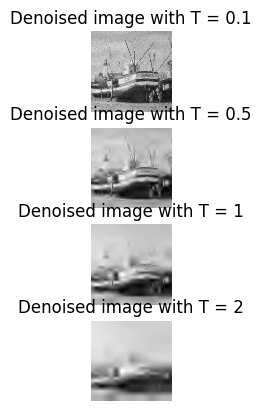

In [72]:
Ts = [0.1, 0.5, 1, 2]
for i, T in enumerate(Ts):
    Fw = perform_wavelet_transf(y, Jmin, +1) # forward transform
    soft_threshold = lambda alpha: np.maximum(0, 1 - (T / np.abs(alpha))) * alpha
    Fw_softed = soft_threshold(Fw)
    recon = perform_wavelet_transf(Fw_softed, Jmin, -1)
    imageplot(recon, f"Denoised image with T = {T}", [len(Ts), 1, i+1])


> Can you comment on the differences between linear and non-linear denoising methods?

Linear denoising methods, such as those based on the Fourier transform, apply linear filters to remove specific frequency components, making them effective for stationary noise but less adaptive to local signal variations. In contrast, non-linear methods like wavelet-based denoising rely on coefficient thresholding, a non-linear operation that selectively suppresses noise while preserving important localized features such as edges and transients. As a result, wavelet denoising is typically more effective for signals with non-stationary or spatially varying noise.

> In addition to visual comparison, it is common to compute the signal-to-noise ratio (SNR) of the denoised image. This can be done by calling the `snr` function built in `signal.py` in the toolbox. The higher the SNR, the better the denoising effect in general.

100%|██████████| 100/100 [00:00<00:00, 457.17it/s]


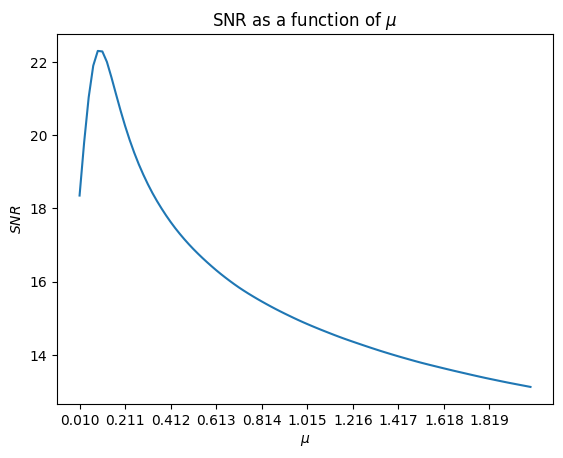

In [79]:
from nt_toolbox.signal import snr
from tqdm import tqdm

Ts = np.linspace(0.01, 2, 100)
snrs = []
for T in tqdm(Ts):
    Fw = perform_wavelet_transf(y, Jmin, +1) # forward transform
    soft_threshold = lambda alpha: np.maximum(0, 1 - (T / np.abs(alpha))) * alpha
    Fw_softed = soft_threshold(Fw)
    recon = perform_wavelet_transf(Fw_softed, Jmin, -1)
    snrs.append(snr(f, recon))

fig, ax = plt.subplots()
ax.plot(Ts, snrs)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$SNR$')
ax.set_xticks(Ts[::10])
ax.set_title(r'SNR as a function of $\mu$')
plt.show()
